 # <center> **RECONOCIMIENTO DE TEXTO NUMÉRICO EN CÉDULAS COLOMBIANAS** </center>

INTEGRANTES:

Juan Ricardo Albarracin 

Diego Poveda

Jefferson Murallas




In [0]:
%tensorflow_version 1.x
import cv2 as cv
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import pandas as pd
from google.colab.patches import cv2_imshow

In [117]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/CVproject/
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/CVproject/'
/content/drive/My Drive/CVproject
/content/drive/My Drive/CVproject


## Importación de imágenes

('img size: ', (448, 724))
('img type: ', dtype('uint8'))


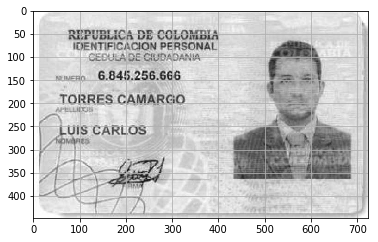

In [118]:
I = cv.imread("data/Cedula1.jpeg", 1) #lea la imagen en numpy array

Igray = cv.cvtColor(I, cv.COLOR_BGR2GRAY) #pasela de rgb a gray

plt.imshow(Igray, cmap='gray'); #mostrar la imagen
plt.grid() # dibuje rejilla
print("img size: ", Igray.shape)
print ("img type: ", Igray.dtype)
#plt.scatter(50,100, marker="x", s=200, linewidth=5, c="b")

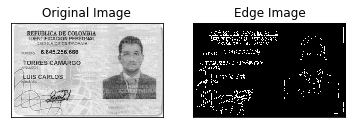

In [119]:
img = cv.imread("data/Cedula1.jpeg")
#img = img.resize(100,100)
edges = cv.Canny(img,100,200)

plt.subplot(121),plt.imshow(Igray,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

## Segmentación de la imagen

(25, 180)

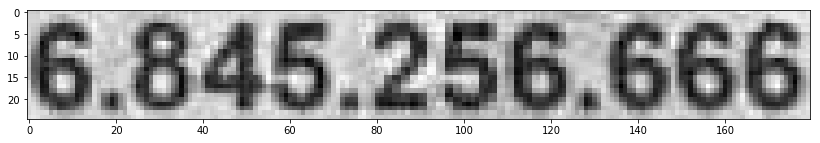

In [120]:
crop_img = Igray[128:153, 140:320]
plt.figure(figsize = (20,2))
plt.imshow(crop_img, cmap='gray')
crop_img.shape

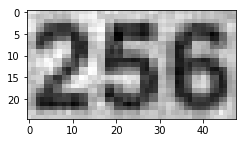

In [121]:
m=164
MIN=132
M=180
crop = crop_img[0:, MIN:]
punto = crop_img[0:, MIN-6:M-48]
crop2= crop_img[0:, MIN-6-(16*3):MIN-6]
plt.figure(figsize = (20,2))
plt.imshow(crop2, cmap='gray')

In [122]:
cut_ims=[]
cut_im=[]
numWsize=16 #16 pixeles de ancho mide cada numero
seq3num=16*3
cutmin=crop_img.shape[1]-(seq3num)
cutmax=crop_img.shape[1]
i=0
for i in range(3):
  crop = crop_img[0:, cutmin:cutmax]
  cutmin=cutmin-seq3num-7
  cutmax=cutmax-seq3num-7
  print (cutmin, cutmax)
  cut_ims.append(crop) 
if(cutmax<18):
  crop = crop_img[0:, 0:cutmax+1]
  cut_im.append(crop)

(77, 125)
(22, 70)
(-33, 15)


In [0]:
cut_ims=np.array(cut_ims)
cedula = []
cedula.append(cut_im[0])
cedula.append(cut_ims[2])
cedula.append(cut_ims[1])
cedula.append(cut_ims[0])

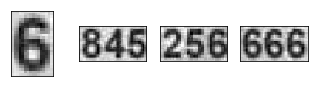

In [124]:
plt.figure(figsize=(7,7))
for i in range(4):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cedula[i], cmap='gray')


In [125]:
cedula[0].shape[1]

16

In [0]:
nums=[]
numWsize=16 #16 pixeles de ancho mide cada numero
cutmin=0
cutmax=16
for i in range(4):
  cutmin=0  
  cutmax=16
  if(cedula[i].shape[1]<=numWsize):
    nums.append(cedula[i])
  else:
    j=0
    while(j<3):
      num = cedula[i][0:, cutmin:cutmax]
      cutmin=cutmin+numWsize
      cutmax=cutmax+numWsize
      nums.append(num)
      j=j+1
  


(25, 16)


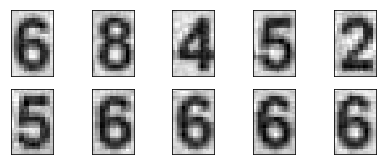

In [127]:
plt.figure(figsize=(7,7))
print(nums[0].shape)
for i in range(len(nums)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(nums[i], cmap='gray')

In [0]:
#ajustamos el tamaño de las imagenes a 28x28
numsA = np.array(nums)
dim = (28,28)
numsR=[]
numsF=[]

for i in range(len(numsA)):
  rez = cv.resize(numsA[i], dim, interpolation = cv.INTER_AREA)
  numsR.append(rez)
  

(28, 28)


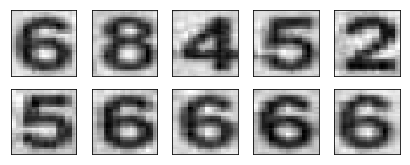

In [129]:
plt.figure(figsize=(7,7))
print(numsR[0].shape)
for i in range(len(numsR)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(numsR[i], cmap='gray')

## Tratamiento de las imagenes

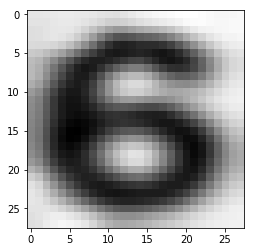

In [130]:
numsBlur = []
for i in range(len(numsR)):
    gris = cv.GaussianBlur(numsR[i], (7, 5), 0)
    numsBlur.append(gris)
    plt.imshow(numsBlur[i], cmap='gray')

(28, 28)


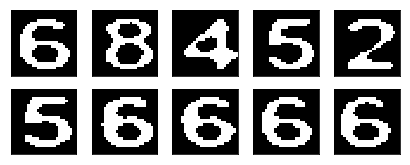

In [131]:
numsB = []
for i in range(len(numsBlur)):
    t, res = cv.threshold(numsBlur[i], 115, 1, cv.THRESH_BINARY_INV)
    numsB.append(res)
    
plt.figure(figsize=(7,7))
print(numsB[0].shape)
for i in range(len(numsB)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(numsB[i], cmap='gray')
    

(28, 28)


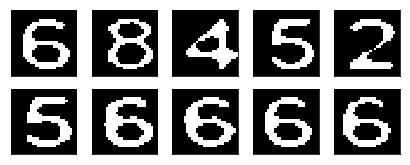

In [132]:
numsB = []
for i in range(len(numsBlur)):
    t, res = cv.threshold(numsBlur[i], 115, 1, cv.THRESH_BINARY_INV)
    numsB.append(res)
se = np.ones((1,2),np.float32)

for i in range(len(numsB)):
  numsB[i] = cv.morphologyEx(numsB[i], cv.MORPH_ERODE, se)

plt.figure(figsize=(7,7))
print(numsB[0].shape)
for i in range(len(numsB)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(numsB[i], cmap='gray')

## Clasificación (MNIST)

In [133]:

mnist = pd.read_csv("data/mnist1.5k.csv.gz", header=None).values.astype(float)
print ("dimension de los datos originales", mnist.shape)
X=mnist[:,1:785]
y=mnist[:,0]
print ("dimension de las imagenes y las clases", X.shape, y.shape)
print ("luminosidad maxima", np.max(X))
print ("luminosidad minimo", np.min(X))

('dimension de los datos originales', (1500, 785))
('dimension de las imagenes y las clases', (1500, 784), (1500,))
('luminosidad maxima', 255.0)
('luminosidad minimo', 0.0)


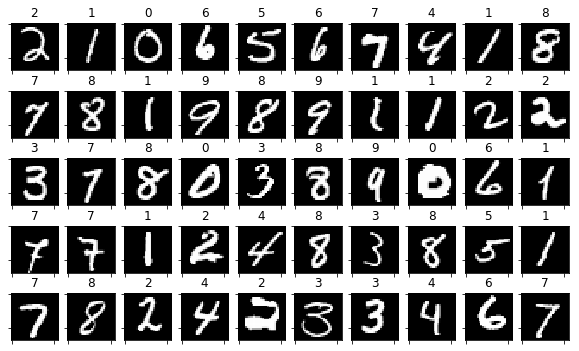

In [134]:
perm = np.random.permutation(range(X.shape[0]))[0:50]
random_imgs   = X[perm]
random_labels = y[perm] 
fig = plt.figure(figsize=(10,6))
for i in range(random_imgs.shape[0]):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(random_imgs[i].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(int(random_labels[i]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

In [135]:
test_size = 0.2
#by defautl is 0.25 in test.

d_train, d_test, c_train, c_test = train_test_split(X, y, test_size=test_size)
print (d_train.shape, d_test.shape)
print (c_train.shape, c_test.shape)

((1200, 784), (300, 784))
((1200,), (300,))


### RandomForestClassifier

In [136]:
est1 = SVC()
est2 = RandomForestClassifier()
s = cross_val_score(est1, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print ("accuracy SCV %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

s1 = cross_val_score(est2, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print ("accuracy RF %.3f (+/- %.5f)"%(np.mean(s1), np.std(s1)))

accuracy SCV 0.099 (+/- 0.01746)
accuracy RF 0.809 (+/- 0.02398)


In [0]:
numsF = []
for i in range(len(numsB)):
  data = numsB[i].flatten()
  numsF.append(data)

In [138]:
est2.fit(X,y)
predictions = est2.predict(numsF)
print( "predictions RandomForest", predictions)

est1.fit(X,y)
predictions = est1.predict(numsF)
print( "predictions SVC", predictions)

('predictions RandomForest', array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7.]))
('predictions SVC', array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]))


### Deep Neural Network DNN

 MNIST
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
('x_train shape:', (60000, 28, 28, 1))
('Number of images in x_train', 60000)
('Number of images in x_test', 10000)


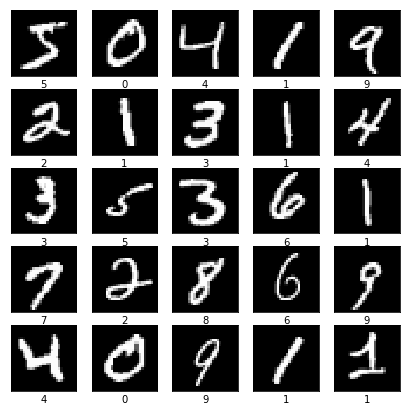

In [139]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])
print " MNIST"
print x_train.shape, y_train.shape, x_test.shape, y_test.shape

class_names = ['0','1','2','3','4','5','6','7','8','9']
plt.figure(figsize=(7,7))
for i in range(25):
    plt.subplot(5,5,i+1)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
    plt.xlabel(class_names[y_train[i]])

x_train = x_train.reshape([-1, 28, 28, 1]) #AGREGAMOS -1 PARA LOS INDICES DE LAS IMAGENES
x_test = x_test.reshape([-1, 28, 28, 1])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255 #NORMALIZAMOS ENTRE CERO Y UNO
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])


In [0]:

model = keras.models.Sequential([
    keras.layers.Flatten( input_shape=[28, 28, 1]), #CAPA DE ENTRADA, RECIBE LAS IMAGENES DE 28x28x1, HACIENDOLE UN FLATTEN/VECTORIZACION DE IMAGENES
    keras.layers.Dense(512, activation=tf.nn.relu), #CAPA OCULTA, densa(conecta todas las entradas)
    keras.layers.Dense(256, activation=tf.nn.relu), #CAPA OCULTA
    keras.layers.Dense(10, activation=tf.nn.softmax) #CAPA DE SALIDA
])


In [141]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [143]:
model.fit(x_train, y_train, batch_size=50, epochs=10, verbose=1)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 48us/sample - loss: 0.1919 - acc: 0.9426
Epoch 2/10
60000/60000 [==============================] - 3s 47us/sample - loss: 0.0767 - acc: 0.9765
Epoch 3/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.0523 - acc: 0.9836
Epoch 4/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.0391 - acc: 0.9878
Epoch 5/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.0313 - acc: 0.9903
Epoch 6/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.0245 - acc: 0.9919
Epoch 7/10
60000/60000 [==============================] - 3s 47us/sample - loss: 0.0228 - acc: 0.9927
Epoch 8/10
60000/60000 [==============================] - 3s 48us/sample - loss: 0.0193 - acc: 0.9937
Epoch 9/10
60000/60000 [==============================] - 3s 49us/sample - loss: 0.0161 - acc: 0.9950
Epoch 10/10
60000/60000 [==============================] - 

In [144]:
for i in range(len(numsB)):
  numsB[i] =  numsB[i].reshape([-1, 28, 28, 1])
preds=[]
for i in range(len(numsB)):
  predictions = model.predict(numsB[i])
  preds.append(np.argmax(predictions))
print "Predicción:", preds  

Predicción: [6, 8, 4, 5, 2, 5, 6, 6, 6, 6]


### Convolutional Neural Network CNN

In [0]:
model_4 =  keras.models.Sequential()
model_4.add(keras.layers.Conv2D(20, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(28, 28, 1))) #
model_4.add(keras.layers.MaxPooling2D((2, 2))) #reduce la imagen
model_4.add(keras.layers.Conv2D(50, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_4.add(keras.layers.MaxPooling2D((2, 2)))
model_4.add(keras.layers.Flatten()) #la aplana
model_4.add(keras.layers.Dense(500, activation='relu', kernel_initializer='he_uniform'))
model_4.add(keras.layers.Dense(10, activation='softmax'))

In [146]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2450)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               1225500   
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

In [147]:
opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
model_4.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model_4.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 61us/sample - loss: 0.3927 - acc: 0.8904 - val_loss: 0.1715 - val_acc: 0.9483
Epoch 2/10
60000/60000 [==============================] - 4s 59us/sample - loss: 0.1329 - acc: 0.9613 - val_loss: 0.0937 - val_acc: 0.9718
Epoch 3/10
60000/60000 [==============================] - 4s 59us/sample - loss: 0.0925 - acc: 0.9734 - val_loss: 0.0802 - val_acc: 0.9759
Epoch 4/10
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0730 - acc: 0.9783 - val_loss: 0.0625 - val_acc: 0.9789
Epoch 5/10
60000/60000 [==============================] - 4s 59us/sample - loss: 0.0618 - acc: 0.9816 - val_loss: 0.0540 - val_acc: 0.9817
Epoch 6/10
60000/60000 [==============================] - 4s 59us/sample - loss: 0.0536 - acc: 0.9839 - val_loss: 0.0550 - val_acc: 0.9811
Epoch 7/10
60000/60000 [==============================] - 3s 58us/sample - loss: 0.0476 - acc: 0.9862 - val_loss: 0.

In [148]:
for i in range(len(numsB)):
  numsB[i] =  numsB[i].reshape([-1, 28, 28, 1])
preds=[]
for i in range(len(numsB)):
  predictions = model_4.predict(numsB[i])
  preds.append(np.argmax(predictions))
print "Predicción:", preds  

Predicción: [5, 8, 4, 5, 2, 5, 5, 5, 5, 5]


## Pruebas

In [0]:
def cutNums(imagen):
  crop_img = imagen[128:153, 140:320]
  plt.figure(figsize = (20,2))
  plt.imshow(crop_img, cmap='gray')


  m=164
  MIN=132
  M=180
  crop = crop_img[0:, MIN:]
  punto = crop_img[0:, MIN-6:M-48]
  crop2= crop_img[0:, MIN-6-(16*3):MIN-6]
  

  cut_ims=[]
  cut_im=[]
  numWsize=16 #16 pixeles de ancho mide cada numero
  seq3num=16*3
  cutmin=crop_img.shape[1]-(seq3num)
  cutmax=crop_img.shape[1]
  i=0
  for i in range(3):
    crop = crop_img[0:, cutmin:cutmax]
    cutmin=cutmin-seq3num-7
    cutmax=cutmax-seq3num-7
    cut_ims.append(crop) 
  if(cutmax<18):
    crop = crop_img[0:, 0:cutmax+1]
    cut_im.append(crop)

  cut_ims=np.array(cut_ims)
  cedula = []
  cedula.append(cut_im[0])
  cedula.append(cut_ims[2])
  cedula.append(cut_ims[1])
  cedula.append(cut_ims[0])
  
  nums=[]
  numWsize=16 #16 pixeles de ancho mide cada numero
  cutmin=0
  cutmax=16
  for i in range(4):
    cutmin=0  
    cutmax=16
    if(cedula[i].shape[1]<=numWsize):
      nums.append(cedula[i])
    else:
      j=0
      while(j<3):
        num = cedula[i][0:, cutmin:cutmax]
        cutmin=cutmin+numWsize
        cutmax=cutmax+numWsize
        nums.append(num)
        j=j+1


  #ajustamos el tamaño de las imagenes a 28x28
  numsA = np.array(nums)
  dim = (28,28)
  numsR=[]
  numsF=[]

  for i in range(len(numsA)):
    rez = cv.resize(numsA[i], dim, interpolation = cv.INTER_AREA)
    numsR.append(rez)

  numsBlur = []
  for i in range(len(numsR)):
    gris = cv.GaussianBlur(numsR[i], (7, 5), 0)
    numsBlur.append(gris)
  numsB = []
  for i in range(len(numsBlur)):
      t, res = cv.threshold(numsBlur[i], 115, 1, cv.THRESH_BINARY_INV)
      numsB.append(res)
      
  
  
  TestAcuracy = []
  numsB = []
  for i in range(len(numsBlur)):
      t, res = cv.threshold(numsBlur[i], 115, 1, cv.THRESH_BINARY_INV)
      numsB.append(res)

  se = np.ones((1,2),np.float32)

  for i in range(len(numsB)):
    numsB[i] = cv.morphologyEx(numsB[i], cv.MORPH_ERODE, se)
    TestAcuracy.append(numsB[i])

 
 
  return numsB , TestAcuracy

In [150]:
cedulas=[]
path = "data/pruebas/"
nombres = os.listdir(path)
for i in nombres:
  I = cv.imread("data/pruebas/" + i, 0)
  #crop_img = I[128:153, 140:320]*1.
  cedulas.append(I)
  print i



Cedula1.jpg
Cedula2.jpg
Sin título-1.jpg
Sin título-8.jpg
cedul.jpeg


Predicción: [2, 8, 4, 5, 2, 5, 3, 2, 2, 7]
Predicción: [7, 0, 5, 7, 8, 8, 3, 5, 9, 3]
Predicción: [8, 9, 7, 7, 5, 9, 5, 5, 5, 5]
Predicción: [1, 0, 3, 0, 7, 2, 0, 5, 2, 2]
Predicción: [7, 8, 5, 2, 8, 2, 0, 8, 0, 8]


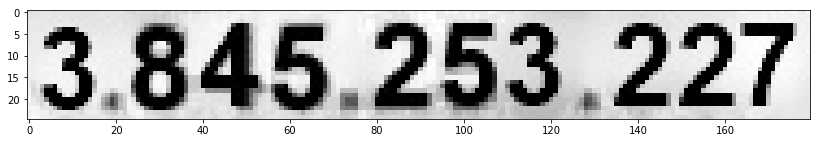

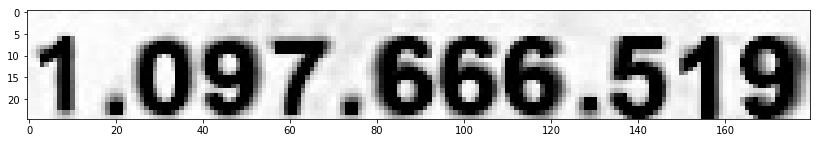

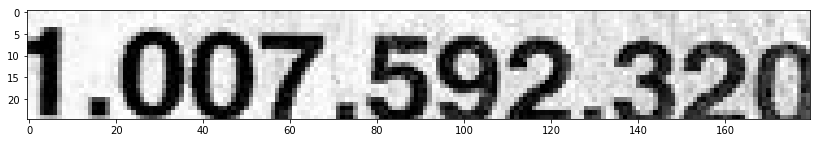

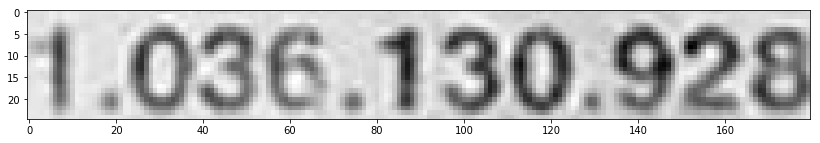

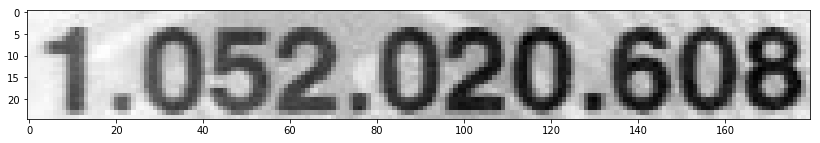

In [151]:
Acuracy = []
for i in range(len(cedulas)):
  y , TestAcuracy= cutNums(cedulas[i])
  for i in range(len(y)):
    y[i] =  y[i].reshape([-1, 28, 28, 1])
  preds=[]
  for i in range(len(y)):
    predictions = model_4.predict(y[i])
    preds.append(np.argmax(predictions))
  for i in TestAcuracy:
    Acuracy.append(i)
  print "Predicción:", preds  

## RESULTADOS

Se hicieron pruebas con 6 diferentes cédulas y se obtuvieron los siguientes resultados:

PRUEBA 0:   7 aciertos de 10 números.

PRUEBA 1:   9 aciertos de 10 números.

PRUEBA 2:   2 aciertos de 10 números.

PRUEBA 3:   2 aciertos de 10 números.

PRUEBA 4:   5 aciertos de 10 números.

PRUEBA 6:   5 aciertos de 10 números.



In [0]:
p = 7./10 + 9./10 + 2./10 + 2./10 + 5./10 + 5./10 

In [153]:
accuracy = p/6.
print "Accuracy:", accuracy

Accuracy: 0.5


In [0]:
#plt.imshow(Acuracy[49])

In [0]:
#Etiquetas = []

In [0]:
#Etiquetas.append(8)

In [0]:
#Etiquetas = np.array(Etiquetas)
#Etiquetas.shape

In [0]:

#Acuracy.size

In [0]:
#for i in range(len(y)):
#   Acuracy[i] =  np.expand_dims(Acuracy[i], axis=3)

In [0]:
#Acuracy.shape

In [0]:
#for i in range(len(Acuracy)):
#  predictions = model_4.predict(Acuracy[i])
#  preds.append(np.argmax(predictions))

In [0]:
#print("%.3f"%accuracy_score(predictions, y))